[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ClimateMatchAcademy/course-content/blob/main/tutorials/W1D4_Paleoclimate/W1D4_Tutorial6.ipynb) &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/{ORG}/course-content/main/tutorials/W1D4_Paleoclimate/W1D4_Tutorial6.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

# **Tutorial 6: Spectral Analysis of Paleoclimate Data**
**Week 1, Day 4, Paleoclimate**

**Content creators:** Sloane Garelick

**Content reviewers:** Yosmely Bermúdez, Dionessa Biton, Katrina Dobson, Maria Gonzalez, Will Gregory, Nahid Hasan, Sherry Mi, Beatriz Cosenza Muralles, Brodie Pearson, Jenna Pearson, Chi Zhang, Ohad Zivan 

**Content editors:** Yosmely Bermúdez, Zahra Khodakaramimaghsoud, Jenna Pearson, Agustina Pesce, Chi Zhang, Ohad Zivan

**Production editors:** Wesley Banfield, Jenna Pearson, Chi Zhang, Ohad Zivan

**Our 2023 Sponsors:** NASA TOPS and Google deepmind

# **Tutorial Objectives**

In this tutorial, you will manipulate paleoclimate proxy datasets using previously learned computational tools, and apply spectral analysis to further interpret the data.


By the end of this tutorial you will be able to:

*   Interpret the LR04 benthic δ<sup>18</sup>O curve and how it records temperature
*   Perform various spectral analysis methods to assess dominant spectral powers in the LR04 data
*   Interpret variations in glacial-interglacial cycles recorded by the LR04 δ<sup>18</sup>O record




# Setup

In [1]:
# imports
import pooch
import os
import tempfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cartopy
import pyleoclim as pyleo

In [2]:
# @title Video 1: Speaker Introduction
#Tech team will add code to format and display the video

In [3]:
# helper functions

def pooch_load(filelocation=None,filename=None,processor=None):
    shared_location='/home/jovyan/shared/Data/tutorials/W1D4_Paleoclimate' # this is different for each day
    user_temp_cache=tempfile.gettempdir()
    
    if os.path.exists(os.path.join(shared_location,filename)):
        file = os.path.join(shared_location,filename)
    else:
        file = pooch.retrieve(filelocation,known_hash=None,fname=os.path.join(user_temp_cache,filename),processor=processor)

    return file

# **Section 1: Plotting the LR04 δ<sup>18</sup>O benthic stack**

We will be analyzing a δ<sup>18</sup>O data from [Lisiecki, L. E., and Raymo, M. E. (2005)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2004PA001071), a stack of 57 globally distributed records of δ<sup>18</sup>O from benthic foraminifera that spans the past ~5 million years. As we learned from the introductory video, δ<sup>18</sup>O of foraminifera records temperature due to differences in the isotopic composition of the ocean during glacial and interglacial periods. The δ<sup>18</sup>O of the ocean (and forams) is more depleted (takes on a smaller values) during interglacials and more enriched (takes on a larger value) during glacials.

Let's start by importing the data:

In [4]:
# Donwload the data
filename_LR04='LR04.csv'
url_LR04='https://raw.githubusercontent.com/LinkedEarth/PyleoTutorials/main/data/LR04.csv'
lr04_data = pd.read_csv(pooch_load(filelocation=url_LR04,filename=filename_LR04), skiprows=4)
lr04_data.head()

,Time (ka),Benthic d18O (per mil),Standard error (per mil)
0,0.0,3.23,0.03
1,1.0,3.23,0.04
2,2.0,3.18,0.03
3,3.0,3.29,0.03
4,4.0,3.30,0.03


We can now create a `Series` object containing the data:

In [5]:
ts_lr04 = pyleo.Series(
    time=lr04_data['Time (ka)'],
    value=lr04_data['Benthic d18O (per mil)  '],
    time_name='Age',
    time_unit='kyr BP',
    value_name='Benthic d18O (per mil)',
    value_unit=u'\u2030',
    label='LR04'
)

Time axis values sorted in ascending order


This record spans the past ~5 million years (5,000 kyr), but we're going to focus in on the past 1 million years (1,000 kyr), so let's create a time slice of just this time period, and plot the time series.

<Axes: xlabel='Age [ka]', ylabel='Benthic d18O (per mil) [‰]'>

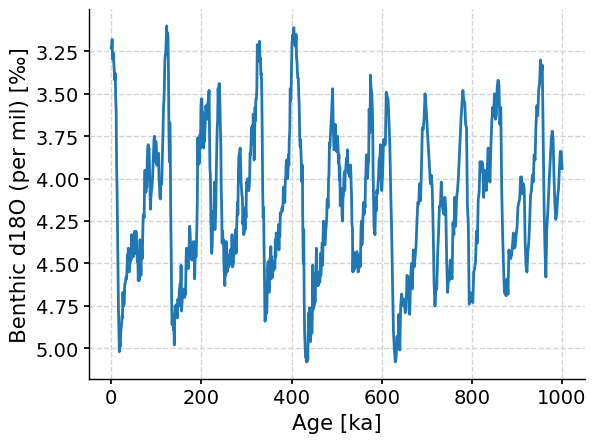

In [6]:
lr04_slice = ts_lr04.slice([0,1000])
fig,ax=plt.subplots() # assign a new plot axis
lr04_slice.plot(ax=ax,legend=False, invert_yaxis=True)

# **Questions 2**

1. What patterns do you observe in the record?
2. Does the amplitude of the glacial-interglacial cycles vary over time?
3. At what frequency do these glacial-interglacial cycles occur?

In [7]:
# to_remove explanation

"""
1. There are cyclical variations in d18O with periods of warmer temperatures (larger d18O) and periods of cooler temperatures (smaller d18O). These temperature changes reflect the glacial-interglacial cycles.
2. It appears as if the amplitudes of the glacial-interglacial cycles increased over the past 1 million years. Specifically, the amplitude changes ~700,000 years ago.
3. It's difficult to determine the temporal frequency at which these glacial-interglacial cycles occur by just looking at the time series. We will explore a computational tool to more accurately determine the length of these cycles. By eye, you might note a ~100,000 year cycle however, among others that are harder to discern.
""";


# **Section 2: Spectral analysis of the LRO4 δ<sup>18</sup>O benthic stack**

To better assess the dominant temporal patterns in this record, you can use spectral analysis. As you learned in the introductory video, spectral analysis is a useful data analysis tool in paleoclimate because it allows us to discover underlying periodicities in time series data and can help establish quantitative relationships between forcings and climate variations.

Let's explore various spectral analysis methods and apply them to the LR04 record to interpret changes in the frequency of glacial-interglacial cycles.



## Section 2.1: Spectral Density

Pyleoclim enables five methods to estimate the [spectral density](https://glossary.ametsoc.org/wiki/Spectral_density), which will be our main interest in this tutorial:

*   **Basic Periodogram**, which uses a Fourier transform. The method has various windowing available to reduce variance.
*  **Welch's periodogram**, a variant of the basic periodogram, which uses Welch's method of overlapping segments. The periodogram is computed on each segment and averaged together.
*   **Multi-taper method (MTM)**, which attempts to reduce the variance of spectral estimates by using a small set of tapers rather than the unique data taper or spectral window.
*   **Lomb-Scargle periodogram**, an inverse approach designed for unevenly-spaced datasets. Several windows are available and Welch's segmentation can also be used with this method.
*   **Weighted wavelet Z-transform (WWZ)**, a wavelet-based method also made for unevenly-spaced datasets.


All of these methods are available through [`Series.spectral()`](https://pyleoclim-util.readthedocs.io/en/latest/core/api.html#pyleoclim.core.series.Series.spectral) by changing the `method` argument. In this tutorial, we'll focus on Lomb-Scargle and Weighted wavelet Z-transform in more detail. For additional information on the other methods, refer to this notebook from [Pyleoclim](https://github.com/LinkedEarth/PyleoTutorials/blob/main/notebooks/L2_spectral_analysis.ipynb).

To get a sense of how the estimates of the spectral density using each of these methods compare, we can plot them on the same graph below. Note we must first interpolate to an even grid and then standardize before estimating the spectral density.

<Axes: xlabel='Period [kas]', ylabel='PSD'>

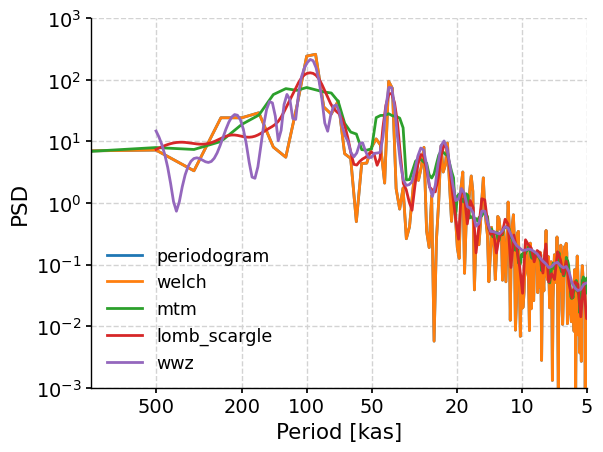

In [8]:
fig,ax=plt.subplots()

# basic periodogram
lr04_slice.interp(step=0.5).standardize().spectral(method='periodogram').plot(ax = ax,
                                                                        xlim=[1000, 5],ylim=[0.001, 1000],
                                                                        label = 'periodogram')
# Welch's periodogram
lr04_slice.interp(step=0.5).standardize().spectral(method='welch').plot(ax = ax,
                                                                        xlim=[1000, 5],ylim=[0.001, 1000],
                                                                        label = 'welch')
# Multi-taper Method
lr04_slice.interp(step=0.5).standardize().spectral(method='mtm').plot(ax = ax,
                                                                        xlim=[1000, 5],ylim=[0.001, 1000],
                                                                        label = 'mtm')
# Lomb-Scargle periodogram
lr04_slice.interp(step=0.5).standardize().spectral(method='lomb_scargle').plot(ax = ax,
                                                                        xlim=[1000, 5],ylim=[0.001, 1000],
                                                                        label = 'lomb_scargle')
# weighted wavelet Z-transform (WWZ)
lr04_slice.interp(step=0.5).standardize().spectral(method='wwz').plot(ax = ax,
                                                                        xlim=[1000, 5],ylim=[0.001, 1000],
                                                                        label = 'wwz')

Which method should you choose? The Lomb-Scargle periodogram is the default method in Pyleoclim, and is a good choice for many applications because: (1) it works with unevenly-spaced timeseries which are often encountered in paleoclimate data, (2) it seems to give consistent results over parameter ranges, (3) doesn't require interpolation, limiting timeseries manipulation, and (4) it is fairly fast to compute. We will choose this estimate to analyze.

(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Period [kas]', ylabel='PSD'>)

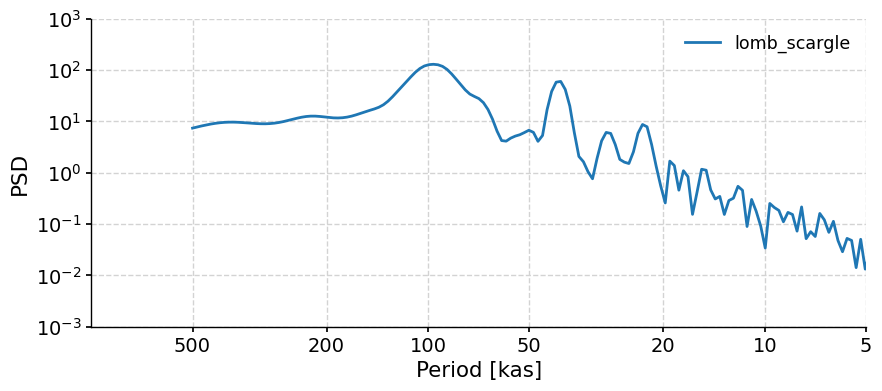

In [9]:
# Lomb-Scargle periodogram
lr04_ls_sd = lr04_slice.interp(step=0.5).standardize().spectral(method='lomb_scargle')

lr04_ls_sd.plot(xlim=[1000, 5],ylim=[0.001, 1000],label = 'lomb_scargle')

# Section 2.2: Significance Testing

Note that there are few peaks that seem more dominant than others, but which of these peaks are significant? That is, do they stand out more than peaks would from a random time series? To figure that out, we can use the method `signif_test`.  Pyleoclim generates many *surrogates* of the time series using an AR(1) (Autoregressive Process of order 1 - i.e. a random process). These surrogates serve to identify the probability of a peak not just being from random noise and the likelihood that the peak of the same magnitude would be unlikely to be present in a random dataset. The default number of surrogates generated is 200, and the larger this value, the more smooth and precise our results are.

In [10]:
lr04_ls_sd_sig = lr04_ls_sd.signif_test()

Performing spectral analysis on individual series: 100%|██████████| 200/200 [00:06<00:00, 29.59it/s]


(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Period [kyrs]', ylabel='PSD'>)

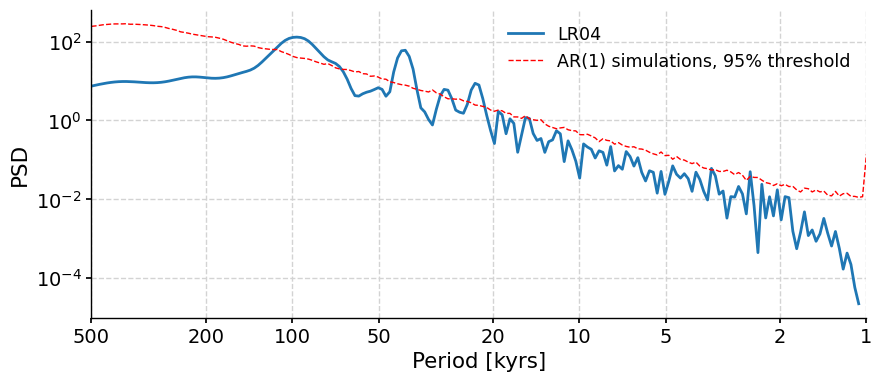

In [11]:
lr04_ls_sd_sig.plot(xlabel='Period [kyrs]')

The variable `lr04_ls_sd_sig` [PSD object](https://pyleoclim-util.readthedocs.io/en/latest/core/api.html#pyleoclim.core.psds.PSD) contains the significant frequencies of the significant peaks from the spectral density of the LR04 data. We can now create the same plot of spectral power, but with only the significant peaks. 

NOTE: For this figure, we will plot the x-axis a bit differently. In the previous plot, the x-axis was the "period" but this time the x-axis will be "frequency", which is the inverse of the period.

Text(0, 0.5, 'Spectra Amplitude')

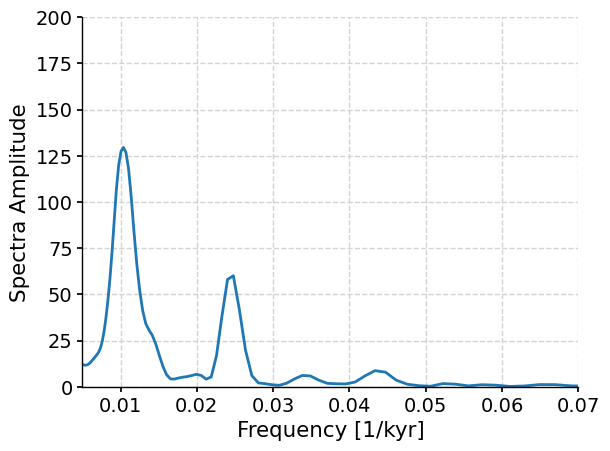

In [12]:
fig,ax=plt.subplots()
ax.plot(lr04_ls_sd_sig.frequency,lr04_ls_sd_sig.amplitude)
ax.set_xlim([0.005, 0.07])
ax.set_ylim([0, 200])
ax.set_xlabel('Frequency [1/kyr]')
ax.set_ylabel('Spectra Amplitude')

The largest spectral powers in the data occur at a frequencies of ~0.01 and ~0.025, as well as a smaller peak at ~0.042, which correspond to 100 kyr, 40 kyr, and 23 kyr, respectively. Do those periodicities sound familiar? 

These are the cycles of **eccentricity, obliquity and precession**. The presence of spectral powers in the LR04 data at the eccentricity, obliquity and precession frequencies highlights the influence of orbital forcings on glacial-interglacial cycles.


## Section 2.3: Wavelet Analysis

Another related tool we can use to learn more about the climate variability recorded in the data is wavelet analysis. This method allows us to  "unfold" a spectrum and look at its evolution over time. In other words, wavelet analysis can help us determine changes in the spectral power over time. For additional details about wavelet analysis, refer to [this guide](https://paos.colorado.edu/research/wavelets/bams_79_01_0061.pdf).

There are several ways to access this functionality in Pyleoclim, but here we use `summary_plot`, which stacks together the timeseries itself in the upper panel, its scalogram (a plot of the magnitude of the wavelet power) in the middle, and the power spectral density (PSD, which we plotted earlier in this tutorial) obtained from summing the wavelet coefficients over time to the right.


In [13]:
# create a scalogram
scal = lr04_slice.interp(step=0.5).standardize().wavelet()

(<Figure size 800x1000 with 4 Axes>,
 {'ts': <Axes: xlabel='Age [ka]', ylabel='Benthic d18O (per mil) [‰]'>,
  'scal': <Axes: xlabel='Age [ka]', ylabel='Scale [kas]'>,
  'psd': <Axes: xlabel='Amplitude'>,
  'cb': <Axes: xlabel='cwt Amplitude'>})

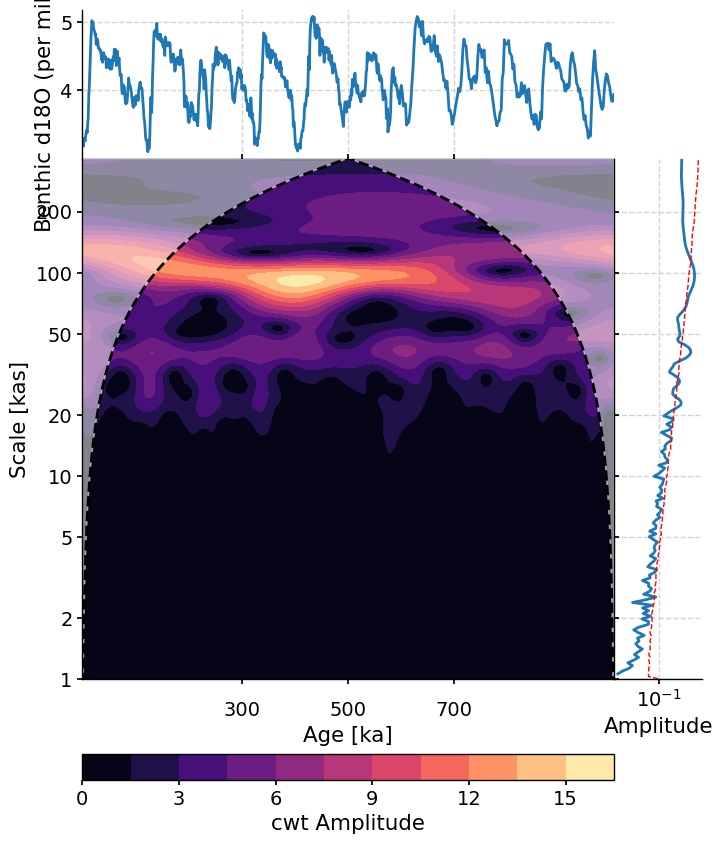

In [14]:
# make plot
lr04_slice.summary_plot(psd=lr04_ls_sd_sig,scalogram=scal,time_lim=[0,1000],psd_label='Amplitude')

In this wavelet spectrum, the age of the record is on the x-axis, the period is on the y-axis, and the color represents the amplitude of that power spectrum, with yellow indicating a higher power and purple indicating a lower power. The time series on top is the original LR04 δ<sup>18</sup>O  data, and the plot on the right is the spectral analysis and significance test figure we created earlier in this tutorial.

### **Questions 2.3: Climate Connection**

1. In the spectral analysis above, the 100 kyr and 40 kyr period are the most dominant. Here, we further see that over the past 1 million years, the 100 kyr cycle is the strongest (as seen by the yellow color at the 100 kyr scale), followed by the 40 kyr cycle (as seen by the light purple color at the 40 kyr scale). You may notice an absence of much color at the 23 kyr scale. What does this suggest about the influence of precession on glacial-interglacial cycles on this timescale?

In [ ]:
# to_remove explanation

"""
The absence of much signal at the 23,000 year scale in the wavelet spectrum suggests that the influence of precession on glacial-interglacial cycles is less significant during this time period. In other words, these glacial-interglacial cycles are not strongly modulated by the precession forcing, which typically occurs every 23,000 years.
"""

# **Summary**
In this tutorial you learned how to analyze paleoclimate proxy datasets using spectral and wavelet analysis.  You were introduced to several spectral analysis methods, identified significant spectral peaks in the spectral density, and looked at the wavelet transform, it's evolution over time. By the end, you were able to determine the influence of various periods, like the 100 kyr and 40 kyr orbital cycles, on glacial-interglacial cycles.

# **Resources**

Code for this tutorial is based on existing notebooks from LinkedEarth for [spectral analysis](https://github.com/LinkedEarth/PyleoTutorials/blob/main/notebooks/L2_spectral_analysis.ipynb) and [wavelet analysis](https://github.com/LinkedEarth/PyleoTutorials/blob/main/notebooks/L2_wavelet_analysis.ipynb).

Data from the following sources are used in this tutorial:

*   Lisiecki, L. E., and Raymo, M. E. (2005), A Pliocene-Pleistocene stack of 57 globally distributed benthic δ<sup>18</sup>O records, Paleoceanography, 20, PA1003,  https://doi.org/10.1029/2004PA001071.